<a href="https://colab.research.google.com/github/Anni1808/MINed_Hackoholics/blob/main/Final_MINed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

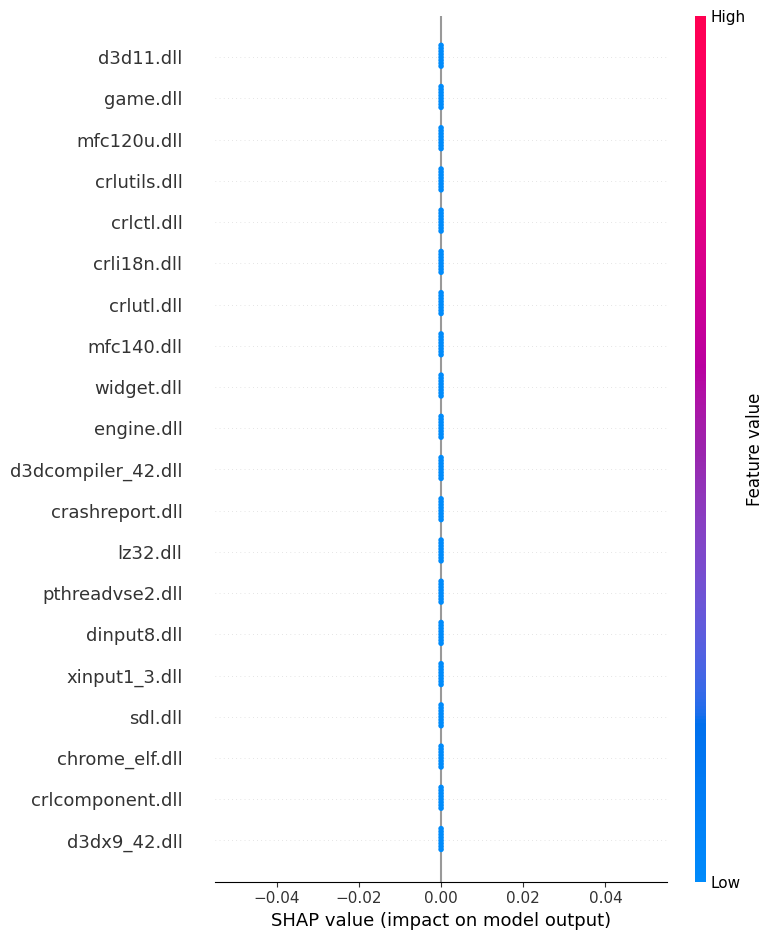

Reduced dataset saved to '/content/reduced_dataset.csv'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import shap
import numpy as np

# Load and preprocess data
df = pd.read_csv("/content/sample_data/DLLs_Imported.csv")

# Preprocessing
features = df.drop(columns=['Type', 'SHA256'])  # Drop 'Type' (target) and 'SHA256' (non-numeric)
target = df['Type'].map({'benign': 0, 'malware': 1})

# Handle NaN values
features = features.fillna(0)
target = target.fillna(0).astype(int)

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Create AdaBoost model
model = AdaBoostClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# SHAP Analysis (using KernelExplainer for AdaBoost)
explainer = shap.KernelExplainer(model.predict, X_train[:8])
shap_values = explainer.shap_values(X_train[:8])

# Visualizations
shap.summary_plot(shap_values, X_train[:8])
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])

# --- Feature Selection and Data Reduction ---

# Get the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame with feature names and mean SHAP values
importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Mean SHAP Value': mean_shap_values
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Mean SHAP Value', ascending=False)

# Select top features
top_n = 10  # Choose the number of top features to keep
important_features = importance_df.head(top_n)['Feature'].tolist()

# Create a new DataFrame with only the selected features
reduced_features = features[important_features]

# Combine with target variable
reduced_df = pd.concat([reduced_features, target], axis=1)

# Store reduced data to CSV
reduced_df.to_csv("/content/reduced_dataset.csv", index=False)
print("Reduced dataset saved to '/content/reduced_dataset.csv'")


In [ ]:
import pandas as pd

# Load the datasets
extractedPE_df = pd.read_csv("/content/sample_data/extractedPE.csv")
reduced_dataset_df = pd.read_csv("/content/sample_data/reduced_dataset.csv")

# Merge the datasets based on the 'SHA256' column
merged_df = pd.merge(extractedPE_df, reduced_dataset_df, on='SHA256', how='inner')

# Save the merged dataset to a new CSV file
merged_df.to_csv("/content/merged_dataset.csv", index=False)
print("Merged dataset saved to '/content/merged_dataset.csv'")

Merged dataset saved to '/content/merged_dataset.csv'


              precision    recall  f1-score   support

           0       0.97      0.83      0.89        35
           1       0.89      0.98      0.93        42
           2       0.95      0.98      0.96        42
           3       0.85      0.65      0.74        43
           4       0.90      0.80      0.85        46
           5       0.57      0.72      0.64        40
           6       0.58      0.66      0.62        32

    accuracy                           0.81       280
   macro avg       0.82      0.80      0.80       280
weighted avg       0.82      0.81      0.81       280



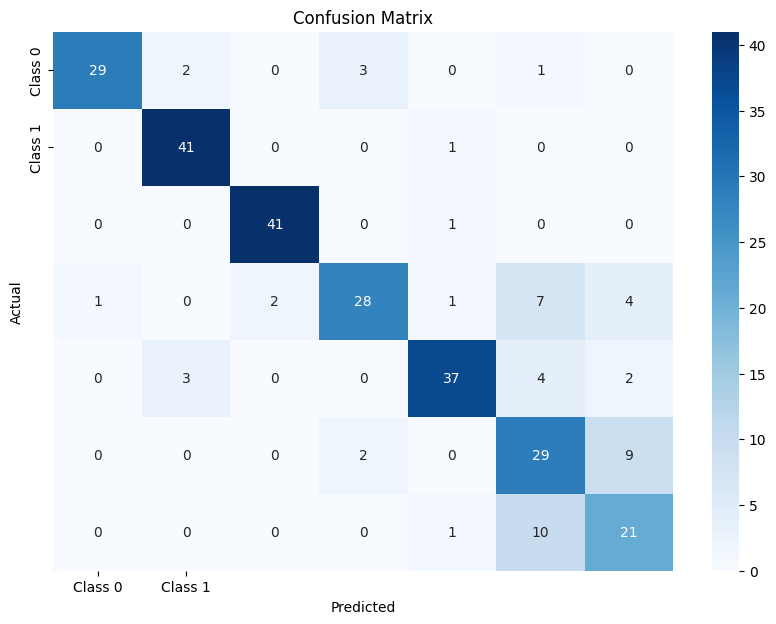

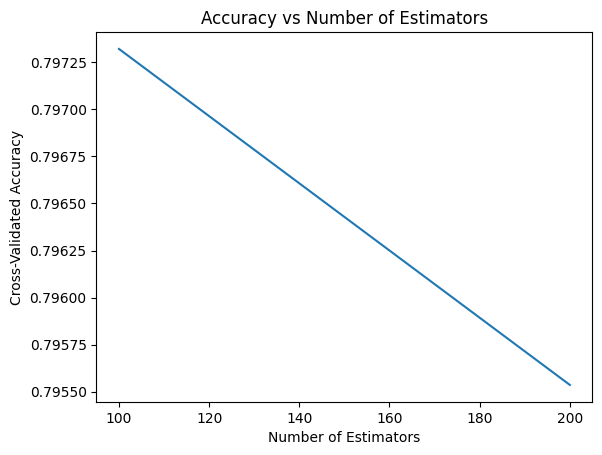

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/content/merged_dataset.csv')

# Resolve Type Columns
df['Target'] = df['Type_x'].combine_first(df['Type_y'])
df.drop(['Type_x', 'Type_y'], axis=1, inplace=True)

# Handle Missing Values using forward fill
df.ffill(inplace=True)

# Encode categorical variables if any exist
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Split Features and Target
X = df.drop('Target', axis=1)
y = df['Target']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement K-Fold Cross-Validation and Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Make Predictions
y_pred = best_model.predict(X_test)

# Evaluation Metrics: Precision and Recall
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plotting Accuracy vs Number of Estimators
n_estimators = [100, 200]
accuracies = []

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    accuracies.append(scores.mean())

plt.plot(n_estimators, accuracies)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Accuracy vs Number of Estimators')
plt.show()


              precision    recall  f1-score   support

           0       0.97      0.83      0.89        35
           1       0.89      0.98      0.93        42
           2       0.95      0.98      0.96        42
           3       0.85      0.65      0.74        43
           4       0.90      0.80      0.85        46
           5       0.57      0.72      0.64        40
           6       0.58      0.66      0.62        32

    accuracy                           0.81       280
   macro avg       0.82      0.80      0.80       280
weighted avg       0.82      0.81      0.81       280



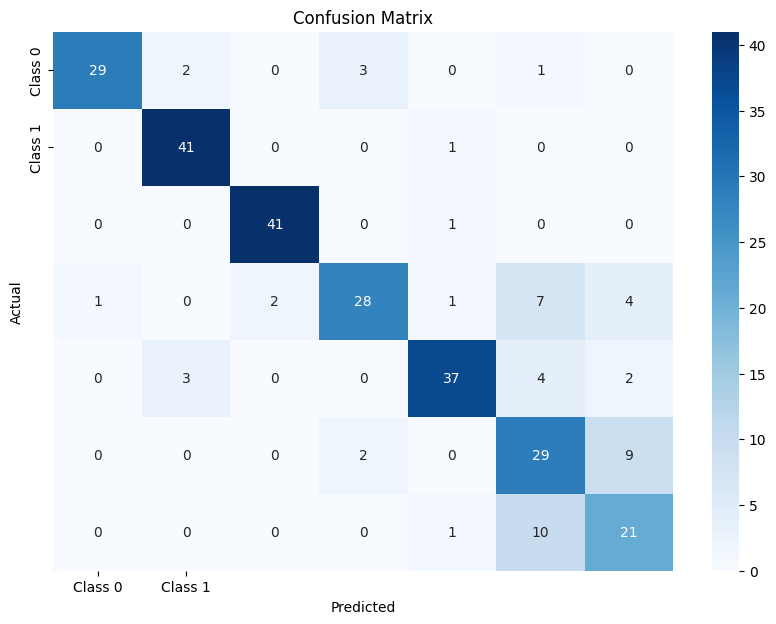

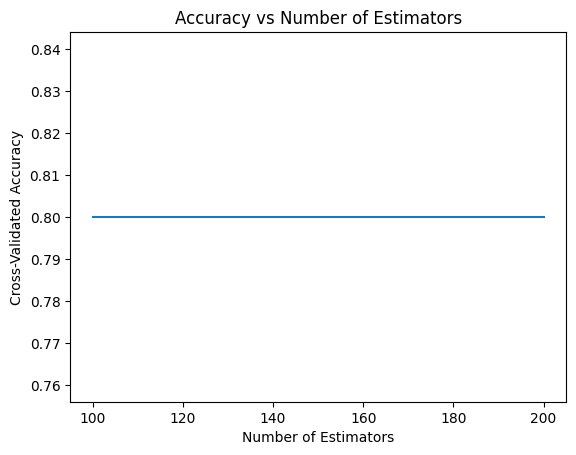

All data with predictions saved to '/content/all_data_with_predictions.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/content/merged_dataset.csv')

# Resolve Type Columns
df['Target'] = df['Type_x'].combine_first(df['Type_y'])
df.drop(['Type_x', 'Type_y'], axis=1, inplace=True)

# Handle Missing Values using forward fill
df.ffill(inplace=True)

# Encode categorical variables if any exist
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Split Features and Target
X = df.drop('Target', axis=1)
y = df['Target']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement K-Fold Cross-Validation and Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Make Predictions on Test Set
y_pred = best_model.predict(X_test)

# Evaluation Metrics: Precision and Recall
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plotting Accuracy vs Number of Estimators
n_estimators = [100, 200]
accuracies = []

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    accuracies.append(scores.mean())

plt.plot(n_estimators, accuracies)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Accuracy vs Number of Estimators')
plt.show()

# --- Prediction on New Test Set ---
# Load the new test dataset (replace with actual path)
test_df = pd.read_csv('/content/sample_data/test.csv')

# Handle Missing Values using forward fill on test data
test_df.ffill(inplace=True)

# Encode categorical variables in test set (using same LabelEncoder if necessary)
for column in test_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])

# Prepare features for prediction (use only columns that were used for training)
X_new = test_df[X.columns]  # Ensure using only columns present in training data

# Make Predictions on the new test set
test_predictions = best_model.predict(X_new)

# Create predictions DataFrame with all columns from test_df
predictions_df = test_df.copy()
predictions_df['Predicted_Type'] = test_predictions

# Map predicted values back to original labels (if necessary)
predictions_df['Predicted_Type'] = predictions_df['Predicted_Type'].map({0: 'benign', 1: 'malware'})

# --- Combine Training and Test Data with Predictions ---
# Add a 'Data_Source' column to identify training and test data
df['Data_Source'] = 'Training'
predictions_df['Data_Source'] = 'Test'

# Concatenate training and test data
all_data_df = pd.concat([df, predictions_df], ignore_index=True)

# Save all data to a CSV file
all_data_df.to_csv("/content/all_data_with_predictions.csv", index=False)
print("All data with predictions saved to '/content/all_data_with_predictions.csv'")


In [ ]:
import pandas as pd

# Load the datasets
test_df = pd.read_csv("/content/sample_data/test.csv")
merged_df = pd.read_csv("/content/merged_dataset.csv")

# Get the common columns
common_columns = list(set(test_df.columns) & set(merged_df.columns))

# Print the common columns
print("Common Columns:", common_columns)

Common Columns: ['Characteristics', 'e_sp', 'edata_SizeOfRawData', 'text_PointerToRelocations', 'data_Misc_VirtualSize', 'tls_PointerToRawData', 'rdata_NumberOfRelocations', 'Subsystem', 'idata_PointerToLinenumbers', 'e_crlc', 'MinorSubsystemVersion', 'tls_NumberOfLinenumbers', 'certca.dll', 'e_cparhdr', 'tls_PointerToLinenumbers', 'rdata_SizeOfRawData', 'certenroll.dll', 'idata_PointerToRelocations', 'edata_NumberOfLinenumbers', 'data_VirtualAddress', 'rsrc_PointerToRelocations', 'reloc_Misc_VirtualSize', 'reloc_NumberOfLinenumbers', 'CheckSum', 'idata_Misc_VirtualSize', 'bss_NumberOfLinenumbers', 'rdata_PointerToLinenumbers', 'idata_SizeOfRawData', 'rdata_Characteristics', 'tls_VirtualAddress', 'Magic', 'e_cp', 'rsrc_Characteristics', 'e_minalloc', 'e_cblp', 'bss_NumberOfRelocations', 'pdata_NumberOfLinenumbers', 'edata_PointerToRelocations', 'e_ovno', 'ImageBase', 'tls_SizeOfRawData', 'reloc_PointerToRawData', 'e_csum', 'MinorOperatingSystemVersion', 'text_NumberOfLinenumbers', 'dat

In [ ]:
import pandas as pd

# Load the datasets
test_df = pd.read_csv("/content/sample_data/test.csv")
merged_df = pd.read_csv("/content/merged_dataset.csv")

# Get the common columns
common_columns = list(set(test_df.columns) & set(merged_df.columns))

In [ ]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv("/content/sample_data/final_merged_dataset.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")

# Assuming 'Type' is the target variable in train_df
target_column = 'Type'  # Change if your target column has a different name

# 1. Add 'Type' column to test_df
test_df[target_column] = 0  # Initialize with a default value (0 in this case)

# 2. Align columns
train_features = train_df.drop(columns=[target_column])  # Features in training data
train_feature_columns = train_features.columns.tolist()

# Select and reorder columns in test data
test_df_aligned = test_df[[col for col in train_feature_columns if col in test_df.columns]]

# Handle missing columns in test data
missing_cols = set(train_feature_columns) - set(test_df_aligned.columns)
for col in missing_cols:
    test_df_aligned[col] = 0  # Fill with 0 or a suitable default

# Add the 'Type' column back to the aligned test data
test_df_aligned[target_column] = test_df[target_column]

# Ensure all columns are in the same order as the training data
test_df_aligned = test_df_aligned[train_df.columns]

# Save aligned test data
test_df_aligned.to_csv("/content/aligned_test.csv", index=False)
print("Aligned test data saved to '/content/aligned_test.csv'")

Aligned test data saved to '/content/aligned_test.csv'


<ipython-input-27-167b31f41b22>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_aligned[col] = 0  # Fill with 0 or a suitable default
<ipython-input-27-167b31f41b22>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_aligned[col] = 0  # Fill with 0 or a suitable default
<ipython-input-27-167b31f41b22>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h